# T5 Fine-tuning

### Import Libraries

In [2]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from datasets import load_dataset
from tqdm import tqdm

### Load Dataset

In [3]:
use_pytorch_training = False

# load tokenizer
tokenizer = AutoTokenizer.from_pretrained('google/t5-v1_1-small')
tokenizer.pad_token = tokenizer.eos_token

# load dataset
dataset = load_dataset("sciq")
train_data = dataset['train']
test_data = dataset['test']

def preprocess_function(dataset):
    dataset["input_ids"] = []
    dataset["attention_mask"] = []
    dataset["labels"] = []
    for index in range(len(dataset['question'])):
        inp = f"|Support| {dataset['support'][index]} |Question| <extra_id_0> |Correct| <extra_id_1> |1st Choice| <extra_id_2> |2nd Choice| <extra_id_3> |3rd Choice| <extra_id_4>"
        exp_out = f"<extra_id_0> {dataset['question'][index]} <extra_id_1> {dataset['correct_answer'][index]} <extra_id_2> {dataset['distractor1'][index]} <extra_id_3> {dataset['distractor2'][index]} <extra_id_4> {dataset['distractor3'][index]}"
        model_inputs = tokenizer(inp, max_length=1024, truncation=True)
        labels = tokenizer(exp_out, max_length=1024, truncation=True)

        dataset["input_ids"].append(model_inputs["input_ids"])
        dataset["attention_mask"].append(model_inputs["attention_mask"])
        dataset["labels"].append(labels["input_ids"])
    return dataset

test_data = test_data.map(preprocess_function, batched=True)
train_data = train_data.map(preprocess_function, batched=True) 
# load model
model = AutoModelForSeq2SeqLM.from_pretrained('google/t5-v1_1-small')

# visualize dataset
print(train_data)
print(type(train_data))

Using custom data configuration default
Reusing dataset sciq (/home/eshaanb/.cache/huggingface/datasets/sciq/default/0.1.0/50e5c6e3795b55463819d399ec417bfd4c3c621105e00295ddb5f3633d708493)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /home/eshaanb/.cache/huggingface/datasets/sciq/default/0.1.0/50e5c6e3795b55463819d399ec417bfd4c3c621105e00295ddb5f3633d708493/cache-0821774cdb657d5e.arrow
Loading cached processed dataset at /home/eshaanb/.cache/huggingface/datasets/sciq/default/0.1.0/50e5c6e3795b55463819d399ec417bfd4c3c621105e00295ddb5f3633d708493/cache-e9041b6d72f8232c.arrow


Dataset({
    features: ['question', 'distractor3', 'distractor1', 'distractor2', 'correct_answer', 'support', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 11679
})
<class 'datasets.arrow_dataset.Dataset'>


### Visualize Dataset

In [4]:
# convert Dataset into pandas
pd.set_option('display.max_colwidth', None)

print(tokenizer.decode(train_data[0]["input_ids"]))
print(tokenizer.decode(train_data[0]["labels"]))
pd.DataFrame(train_data).head(1)

|Support| Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine. |Question| <extra_id_0> |Correct| <extra_id_1> |1st Choice| <extra_id_2> |2nd Choice| <extra_id_3> |3rd Choice| <extra_id_4></s>
<extra_id_0> What type of organism is commonly used in preparation of foods such as cheese and yogurt? <extra_id_1> mesophilic organisms <extra_id_2> protozoa <extra_id_3> gymnosperms <extra_id_4> viruses</s>


,question,distractor3,distractor1,distractor2,correct_answer,support,input_ids,attention_mask,labels
0,What type of organism is commonly used in preparation of foods such as cheese and yogurt?,viruses,protozoa,gymnosperms,mesophilic organisms,"Mesophiles grow best in moderate temperature, typically between 25°C and 40°C (77°F and 104°F). Mesophiles are often found living in or on the bodies of humans or other animals. The optimal growth temperature of many pathogenic mesophiles is 37°C (98°F), the normal human body temperature. Mesophilic organisms have important uses in food preparation, including cheese, yogurt, beer and wine.","[1820, 134, 413, 1493, 9175, 10162, 21144, 15, 7, 1604, 200, 16, 8107, 2912, 6, 3115, 344, 944, 1956, 254, 11, 1283, 1956, 254, 41, 4013, 1956, 371, 11, 3, 15442, 1956, 371, 137, 10162, 21144, 15, 7, 33, 557, 435, 840, 16, 42, 30, 8, 5678, 13, 6917, 42, 119, 3127, 5, 37, 6624, 1170, 2912, 13, 186, 2071, 20853, 140, 7, 21144, 15, 7, 19, 6862, 1956, 254, 41, 3916, 1956, 371, 201, 8, 1389, 936, 643, 2912, 5, 10162, 21144, 447, 9329, 7, 43, 359, 2284, 16, 542, 4537, 6, 379, 3285, 6, 19168, 6, 6061, 11, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]","[32099, 363, 686, 13, 9329, 19, 5871, 261, 16, 4537, 13, 4371, 224, 38, 3285, 11, 19168, 58, 3, 32098, 140, 7, 21144, 447, 9329, 7, 3, 32097, 23844, 172, 32, 9, 3, 32096, 7868, 4844, 883, 51, 7, 3, 32095, 19601, 1]"


### Transformers' Seq2Seq Training

In [ ]:

# see https://huggingface.co/docs/transformers/tasks/summarization

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    learning_rate=5e-4,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=10,
    eval_accumulation_steps=10,
    weight_decay=0.01,
    num_train_epochs=15,
    fp16=True,
    save_total_limit=5,
)
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

## Test

In [13]:
from random import shuffle, randint
# load model from checkpoint 
prompt = "Natural Language Processing is a field of artificial intelligence in which computers analyze, understand, and derive meaning from human language in a smart and useful way. By utilizing NLP, developers can organize and structure knowledge to perform tasks such as automatic summarization, translation, named entity recognition, relationship extraction, sentiment analysis, speech recognition, and topic segmentation. 'Apart from common word processor operations that treat text like a mere sequence of symbols, NLP considers the hierarchical structure of language: several words make a phrase, several phrases make a sentence and, ultimately, sentences convey ideas,' John Rehling. “By analyzing language for its meaning, NLP systems have long filled useful roles, such as correcting grammar, converting speech to text and automatically translating between languages.” NLP is used to analyze text, allowing machines to understand how humans speak. This human-computer interaction enables real-world applications like automatic text summarization, sentimental analysis, topic extraction, named entity recognition, parts-of-speech tagging, relationship extraction, stemming, and more. NLP is characterized as a difficult problem in computer science. Human language is rarely precise, or plainly spoken. To understand human language is to understand not only the words, but the concepts and how they’re linked together to create meaning. Despite language being one of the easiest things for the human mind to learn, the ambiguity of language is what makes natural language processing a difficult problem for computers to master."
PATH = "./results/checkpoint-17500"
tokenizer = AutoTokenizer.from_pretrained(PATH, local_files_only=True)
model = AutoModelForSeq2SeqLM.from_pretrained(PATH, local_files_only=True)
input_ids = tokenizer(prompt, return_tensors="pt").input_ids
outputs = model.generate(input_ids)
print(f"{tokenizer.decode(outputs[0])}")

<pad> What is the field of artificial intelligence in which computers analyze, understand, and derive meaning from


## Visualize Dataset

                Step  Training Loss
0   500     1.735800            NaN
1               1000         1.5539
2               1500         1.3722
3               2000         1.3567
4               2500         1.2620
5               3000         1.1956
6               3500         1.1736
7               4000         1.0536
8               4500         1.0692
9               5000         0.9834
10              5500         0.9583
11              6000         0.9562
12              6500         0.8660
13              7000         0.9006
14              7500         0.7917
15              8000         0.8169
16              8500         0.7702
17              9000         0.7709
18              9500         0.7285
19             10000         0.6915
20             10500         0.6992
21             11000         0.6388
22             11500         0.6478
23             12000         0.6173
24             12500         0.6195
25             13000         0.5904
26             13500        

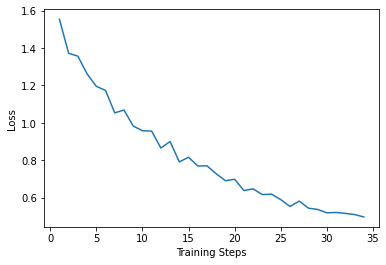

In [5]:
# read csv 
df = pd.read_csv("loss.csv", delimiter="\t")
print(df)
# matplotlib the loss
import matplotlib.pyplot as plt
plt.plot(df["Training Loss"])
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()